In [1]:
from datamodule.datamodule import *
from distributions.distributions import *
from utils import *
# MODEL:
from model.deepGARv1 import DeepGAR
# PYTORCH LIGHTNING:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
#

In [2]:

name = 'electric'  # electric
train_size = 0.7
validation_size = 0.15
test_size = 0.15
batch_size = 32
custom_datamodule = DataModule(name, (train_size, validation_size, test_size), batch_size=batch_size)

In [3]:
train_window = 48
test_window = 48
test_horizon = 24
test_stride = 24 # should be equal to the time horizon
test_delay = 0
train_loader, val_loader, test_loader = custom_datamodule.get_all(
    window=train_window,
    test_window=test_window,
    test_horizon=test_horizon,
    test_stride=test_stride,
    test_delay=test_delay
)

Train (5170, 370), val (639, 370), test (216, 370). ORIGINAL (6025, 370)


In [4]:
input_size = custom_datamodule.get_channels()
n_nodes = custom_datamodule.get_number_of_nodes()

distribution = GaussianDistribution()  # or StudentTDistribution()

test_loss = 'rmse'  # or 'mae'

perform_scaling = False

In [5]:

def run_model(run, train=False, testing=True, checkpoint_callback_path:str=None, tuning=False):
    res = None
    model = DeepGAR(
        input_size=input_size,
        n_nodes=n_nodes,
        distribution=distribution,
        perform_scaling=perform_scaling
    )
    print(model)
    print_model_size(model)

    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00,
        patience=60,
        mode='min'
    )
    checkpoint_callback = ModelCheckpoint(
        dirpath=f'electricity_logs_{run}',
        save_top_k=1,
        monitor='val_loss',
        mode='min',
    )
    trainer = pl.Trainer(
        max_epochs=1000,
        accelerator='cuda' if torch.cuda.is_available() else 'cpu',
        devices = 1,
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=150,
        # auto_lr_find=True if tuning else False
    )
    # if tuning:
    #     lr_finder = trainer.tuner.lr_find(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    #     lr_finder.results
    #     fig = lr_finder.plot(suggest=True)
    #     fig.show()

    #     # Pick point based on plot, or get suggestion
    #     new_lr = lr_finder.suggestion()
    #     print(new_lr)
    if train:
        trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    # delete all
    if testing:
        best_model_path = checkpoint_callback.best_model_path
        if len(best_model_path) < 1 and checkpoint_callback_path is None:
            raise RuntimeError(f'failed to locate best model checkpoint path. Stopping at run {run}')
        elif len(best_model_path) < 1:
            best_model_path= checkpoint_callback_path
        best_model = DeepGAR.load_from_checkpoint(
        checkpoint_path=best_model_path
        )
        print(f'Using checkpoint {best_model_path}')
        best_model.eval()
        res = trainer.predict(model=best_model, dataloaders=test_loader)
        rmse_loss, nd_loss = get_metrics(res, horizon=test_horizon, n_nodes=n_nodes)
        print(f'Run {run} on {name}: RMSE: {rmse_loss}, ND: {nd_loss}')
        add_metrics(name, rmse_loss, nd_loss)

    
    try:
        del model
        del early_stopping_callback
        del checkpoint_callback
        del trainer
        if testing:
            del best_model
    except:
        pass
    return res
    


# list_available_models()

In [8]:

results = []
train_n_times = 1
for i in range(train_n_times):
    res = run_model(i, 
                    train=True, 
                    testing=True, 
                    )
    if res is not None:
        results.append(res)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


DeepGAR(
  (train_loss_fn): NLL()
  (test_loss_fn): RMSE_paper()
  (distribution_sigma): Softplus(beta=1, threshold=20)
  (encoder): Linear(in_features=1, out_features=32, bias=True)
  (node_embeddings): NodeEmbedding(n_nodes=370, embedding_size=32)
  (time): MultiLSTMCell(hidden_size=32)
  (space_time): GraphConvLSTMCell(hidden_size=32)
  (space_time_2): GraphConvLSTMCell(hidden_size=32)
  (distribution_mu): Linear(in_features=32, out_features=1, bias=True)
  (distribution_presigma): Linear(in_features=32, out_features=1, bias=True)
)
Number of model (DeepGAR) parameters:   3123394
Using checkpoint ./electricity_logs_2/epoch=277-step=44758.ckpt


/Users/marziolunghi/Documents/GitHub/DeepGAR/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

(1, 370, 168)
(1, 370, 168)
(370, 168)
(370, 168)
Run 2 on electric: RMSE: 0.4192511233733541, ND: 0.1473975032567978


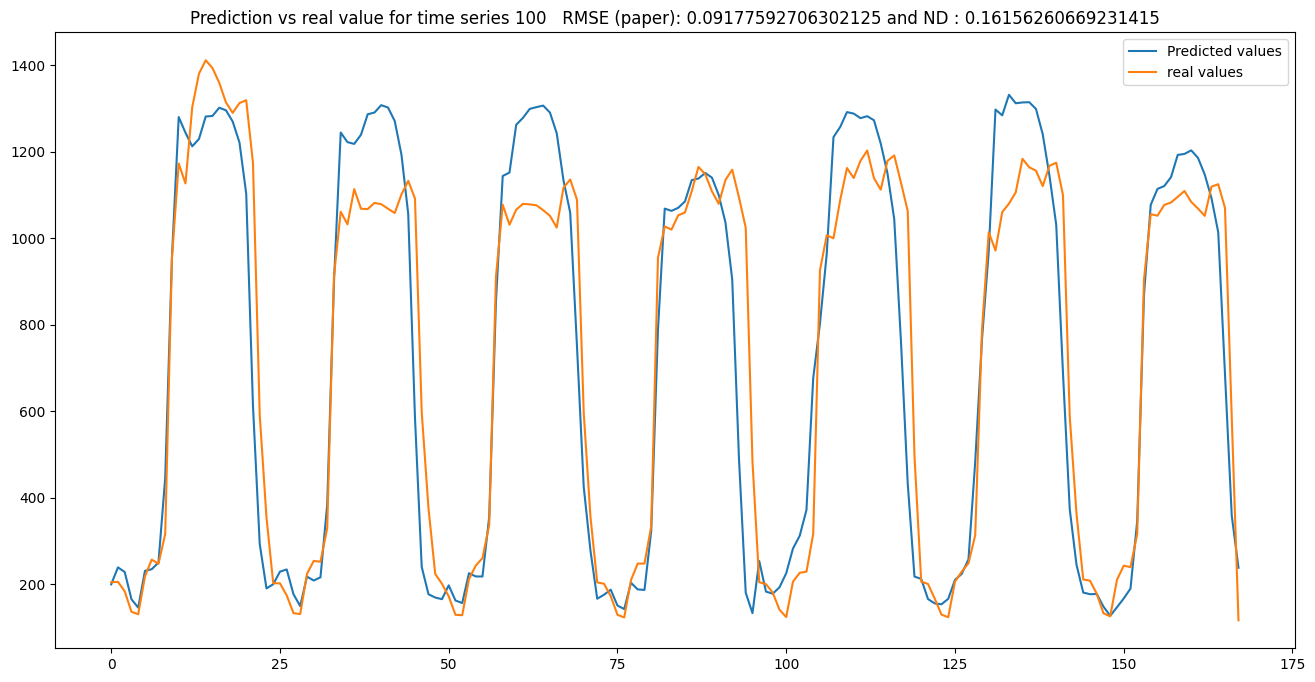

In [13]:
draw_single(res, 100, horizon=test_horizon, n_nodes=n_nodes)